### 1. Imports y lectura de datos

In [1]:
import os
import json

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from torch import nn, optim

from huggingface_hub import login

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix

In [2]:
tkn = ''
login(tkn)

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [3]:
# load data
cajcodes = pd.read_parquet("../data/embeddings/cajcodes-embeddings.parquet")
tweets = pd.read_parquet("../data/embeddings/tweets-embeddings.parquet")

### 2. Descarga de politicalBiasBERT preentrenado

In [4]:
# Load model DistilBERT
model_id = "kangelamw/RoBERTa-political-bias-classifier-softmax"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model_bert = AutoModelForSequenceClassification.from_pretrained(model_id).to(device)
model_bert.eval();

### 3. Entrenamiento sobre ```political-leaning-tweets```

#### a. Google Embeddings + LogReg

In [5]:
X = np.vstack(tweets["embedding"].values)
y = tweets["label"].values

X_train, X_test, y_train_raw, y_test_raw = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

le = LabelEncoder().fit(y_train_raw)
y_train, y_test = le.transform(y_train_raw), le.transform(y_test_raw)

In [6]:
pipe = Pipeline([("scaler", StandardScaler()),
                 ("logreg", LogisticRegression(penalty="l2", solver="lbfgs", max_iter=2000, random_state=42))])

param_grid = {"logreg__C": np.logspace(-2, .1, 10)}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

gs = GridSearchCV(pipe, param_grid, scoring="accuracy", cv=cv, n_jobs=-1, refit=True)
gs.fit(X_train, y_train)

best_lr = gs.best_estimator_
print(f"\n[LogReg] best C = {gs.best_params_['logreg__C']:.6g}")
print(f"Best model's acc: {round(best_lr.score(X_test, y_test), 3)}")


[LogReg] best C = 0.01
Best model's acc: 0.759


#### b. Google Embeddings + MLP

In [7]:
mlp_model = nn.Sequential(
    nn.Linear(X_train.shape[1], 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(le.classes_)),
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=6e-4)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t  = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t  = torch.tensor(y_test, dtype=torch.long).to(device)

In [8]:
for epoch in range(81):
    optimizer.zero_grad()
    out = mlp_model(X_train_t)
    loss = criterion(out, y_train_t)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        # --- métricas train ---
        with torch.inference_mode():
            pred_train = out.argmax(dim=1)
            acc_train = (pred_train == y_train_t).float().mean().item()

            # --- métricas test ---
            mlp_model.eval()
            out_test = mlp_model(X_test_t)
            pred_test = out_test.argmax(dim=1)
            acc_test = (pred_test == y_test_t).float().mean().item()
        print(f"Epoch {epoch:03d} | loss={loss.item():.4f} | train_acc={acc_train:.4f} | test_acc={acc_test:.4f}")


Epoch 000 | loss=1.0993 | train_acc=0.3333 | test_acc=0.3335
Epoch 010 | loss=1.0282 | train_acc=0.7062 | test_acc=0.7006
Epoch 020 | loss=0.8188 | train_acc=0.7282 | test_acc=0.7177
Epoch 030 | loss=0.6285 | train_acc=0.7496 | test_acc=0.7456
Epoch 040 | loss=0.5671 | train_acc=0.7746 | test_acc=0.7604
Epoch 050 | loss=0.5313 | train_acc=0.7889 | test_acc=0.7684
Epoch 060 | loss=0.5069 | train_acc=0.8007 | test_acc=0.7661
Epoch 070 | loss=0.4880 | train_acc=0.8077 | test_acc=0.7701
Epoch 080 | loss=0.4721 | train_acc=0.8138 | test_acc=0.7701


### 4. Evaluación de modelos en ```cajcodes```

Se decidió entrenar en tweets y evaluar en cajcodes dado que el segundo es más sencillo de predecir, dado que está generado con GPT.

In [9]:
X_caj = np.vstack(cajcodes["embedding"].values)
y_caj_raw = cajcodes["label"].values
y_caj = le.transform(y_caj_raw)

#### a. LogReg

In [10]:
y_pred_lr_caj = best_lr.predict(X_caj)
acc_lr_caj = accuracy_score(y_caj, y_pred_lr_caj)
print(f"[LogReg L2] tweets(train) -> cajcodes accuracy = {acc_lr_caj:.4f}\n")
print(classification_report(y_caj, y_pred_lr_caj, target_names=le.classes_))

[LogReg L2] tweets(train) -> cajcodes accuracy = 0.4475

              precision    recall  f1-score   support

           C       0.00      0.00      0.00       201
           L       0.35      0.98      0.52       195
           R       0.93      0.39      0.55       261

    accuracy                           0.45       657
   macro avg       0.43      0.46      0.36       657
weighted avg       0.47      0.45      0.37       657



#### b. RoBERTa

In [11]:
texts = cajcodes["text"].astype(str).tolist()
y_true_int = y_caj  # enteros codificados
labels_original = np.array(y_caj_raw)  # nombres originales
classes_order = list(pd.Index(labels_original).unique())

batch_size = 32
all_preds_int = []

def iter_batches(seq, batch_size):
    for i in range(0, len(seq), batch_size):
        yield seq[i:i+batch_size]
        
with torch.no_grad():
    for batch_texts in iter_batches(texts, batch_size):
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=256,
            return_tensors="pt"
        ).to(device)

        outputs = model_bert(**enc)
        logits = outputs.logits  # (B, num_labels)
        preds = torch.argmax(logits, dim=-1)
        all_preds_int.extend(preds.cpu().numpy())

y_pred_bert_caj = np.array(all_preds_int)

In [12]:
report = classification_report(
    y_caj,
    y_pred_bert_caj,
    target_names=["L", "C", "R"],
    digits=4
)

acc_lr_bert = accuracy_score(y_caj, y_pred_bert_caj)
print(f"\n[Pretrained RoBERTa] tweets(train) -> cajcodes accuracy = {round(acc_lr_bert, 3)}")
print("Classification Report - RoBERTa Political Bias\n")
print(report)


[Pretrained RoBERTa] tweets(train) -> cajcodes accuracy = 0.285
Classification Report - RoBERTa Political Bias

              precision    recall  f1-score   support

           L     0.2993    0.2040    0.2426       201
           C     0.2643    0.6154    0.3698       195
           R     0.3939    0.0996    0.1590       261

    accuracy                         0.2846       657
   macro avg     0.3192    0.3063    0.2571       657
weighted avg     0.3265    0.2846    0.2472       657



### c. MLP

In [13]:
X_caj_t = torch.tensor(X_caj, dtype=torch.float32, device=device)
y_caj_t = torch.tensor(y_caj, dtype=torch.long, device=device)

mlp_model.eval()
with torch.inference_mode():
    logits = mlp_model(X_caj_t)
    y_pred_caj_t = logits.argmax(dim=1)

y_pred_caj_mlp = y_pred_caj_t.detach().cpu().numpy()

# --- métricas ---
acc_caj = accuracy_score(y_caj_t.cpu(), y_pred_caj_mlp)
print(f"[MLP (PyTorch)] Cajcodes(train) -> Twinviews accuracy = {acc_caj:.4f}")
print(classification_report(y_caj_t.cpu(), y_pred_caj_mlp, target_names=le.classes_))

[MLP (PyTorch)] Cajcodes(train) -> Twinviews accuracy = 0.4460
              precision    recall  f1-score   support

           C       0.00      0.00      0.00       201
           L       0.35      0.99      0.52       195
           R       0.91      0.38      0.54       261

    accuracy                           0.45       657
   macro avg       0.42      0.46      0.35       657
weighted avg       0.47      0.45      0.37       657



/Users/diegolarraguibel/Desktop/Proyectos/inclinacion_politica/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/diegolarraguibel/Desktop/Proyectos/inclinacion_politica/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/diegolarraguibel/Desktop/Proyectos/inclinacion_politica/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted sampl

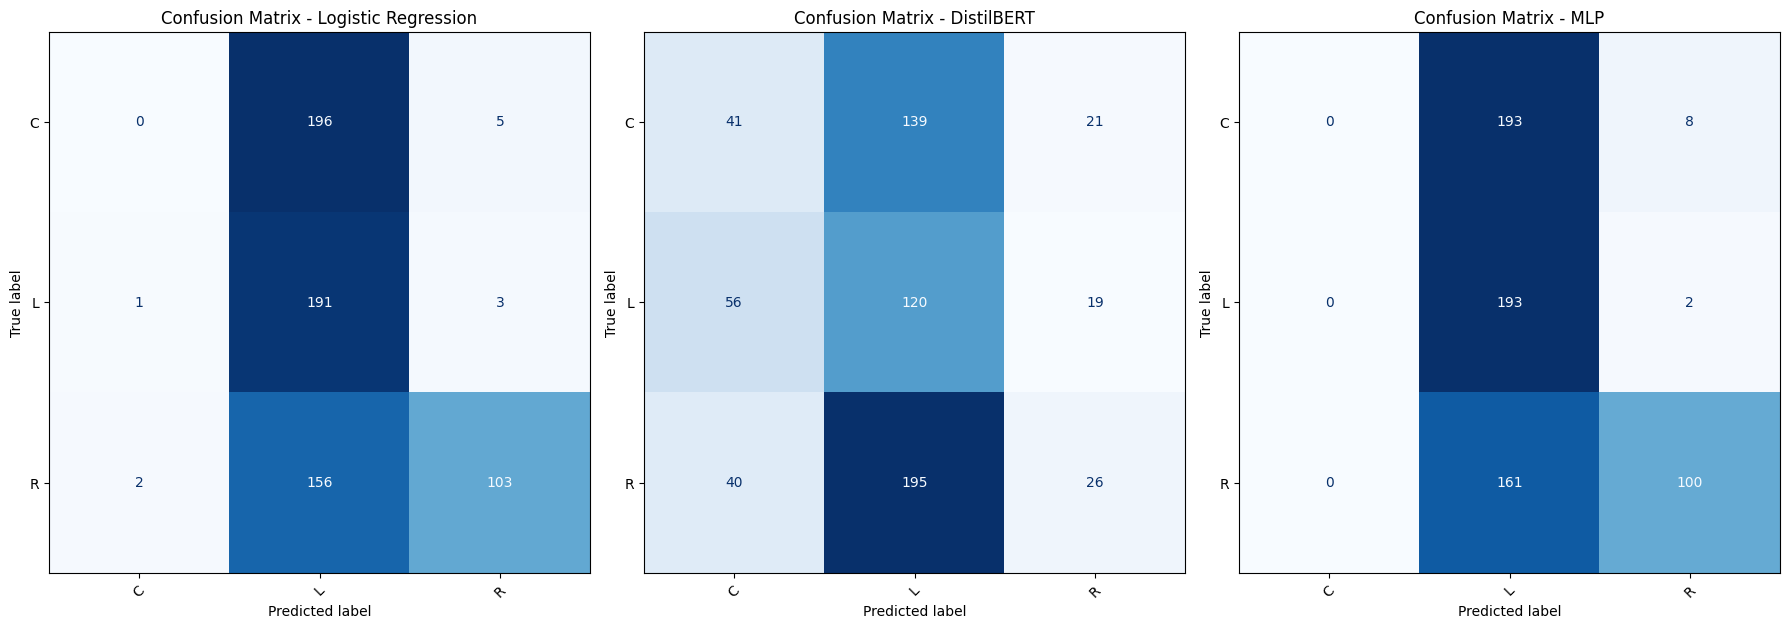

In [14]:
cm_lr   = confusion_matrix(y_caj, y_pred_lr_caj)
cm_bert = confusion_matrix(y_caj, y_pred_bert_caj)
cm_mlp  = confusion_matrix(y_caj, y_pred_caj_mlp)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Logistic Regression
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=le.classes_)
disp_lr.plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Confusion Matrix - Logistic Regression")

# DistilBERT
disp_bert = ConfusionMatrixDisplay(confusion_matrix=cm_bert, display_labels=le.classes_)
disp_bert.plot(ax=axes[1], cmap="Blues", colorbar=False)
axes[1].set_title("Confusion Matrix - DistilBERT")

# MLP
disp_mlp = ConfusionMatrixDisplay(confusion_matrix=cm_mlp, display_labels=le.classes_)
disp_mlp.plot(ax=axes[2], cmap="Blues", colorbar=False)
axes[2].set_title("Confusion Matrix - MLP")

for ax in axes:
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()